<style>
/* Removed the pulse animation */
</style>

<div style="
  background-size: cover;
  padding: 10px;
  border-radius: 20px;
">
  <h1 style="
    color: #AED2FF;
    font-weight: bold;
    text-align: center;
  ">Bone Fracture Data</h1>
</div>


In [1]:
import numpy as np
import cv2
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore
import random

2025-05-13 12:31:55.152728: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 12:31:55.267637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747128715.315026   26432 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747128715.329602   26432 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747128715.420744   26432 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

<style>
    .hero{
        background: linear-gradient(to right, #3F72AF, #BBE1FA);
        -webkit-background-clip: text;
        background-clip: text;
        color: transparent;
        font-size: 2.5em;
        font-weight: bold;
        margin-top:0 ; }
    .text-center{
        text-align: center;
    }
</style>
<h3 class="hero text-center">Preparing the data</h3>


In [2]:
foldername="data"
Dirs=["train","test","val"]
train_dir = os.path.join(foldername, Dirs[0])
classes=[d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
print(classes)

['fractured', 'not fractured']


<style>
    .hero{
        background: linear-gradient(to right, #3F72AF, #BBE1FA);
        -webkit-background-clip: text;
        background-clip: text;
        color: transparent;
        font-size: 2.5em;
        font-weight: bold;
        margin-top:0 ; }
    .text-center{
        text-align: center;
    }
</style>
<h3 class="hero text-center">Loading the images and labels</h3>
<p class="text-center"> A list for images and a corresponding one for labels</p>

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Loaded 9243 training images


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Loaded 506 test images


libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Loaded 829 validation images


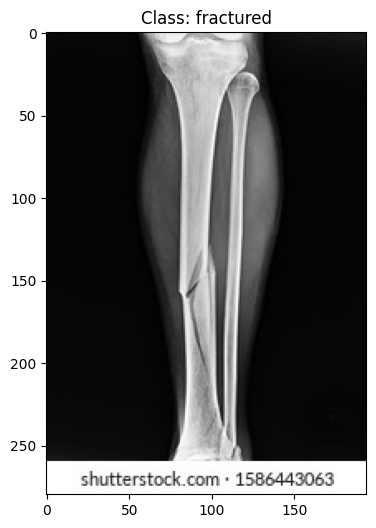

In [3]:
train_images = []
train_labels = []
test_images = []
test_labels = []
val_images = []
val_labels = []

def load_images_from_dir(directory, images_list, labels_list):
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images_list.append(img)
                labels_list.append(class_name)
    return len(images_list)

train_count = load_images_from_dir(os.path.join(foldername, Dirs[0]), train_images, train_labels)
print(f"Loaded {train_count} training images")

test_count = load_images_from_dir(os.path.join(foldername, Dirs[1]), test_images, test_labels)
print(f"Loaded {test_count} test images")

val_count = load_images_from_dir(os.path.join(foldername, Dirs[2]), val_images, val_labels)
print(f"Loaded {val_count} validation images")

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
val_labels_encoded = label_encoder.transform(val_labels)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(train_images[0], cv2.COLOR_GRAY2RGB))
plt.title(f"Class: {train_labels[0]}")
plt.show()



<style>
    .hero{
        background: linear-gradient(to right, #3F72AF, #BBE1FA);
        -webkit-background-clip: text;
        background-clip: text;
        color: transparent;
        font-size: 2.5em;
        font-weight: bold;
        margin-top:0 ; }
    .text-center{
        text-align: center;
    }
</style>
<h3 class="hero text-center">Applying sift</h3>
<p class="text-center"> to get our descriptor</p>

In [4]:
sift = cv2.SIFT_create(sigma=0.8, nOctaveLayers=4, contrastThreshold=0.12)

def get_descriptors(images: list):
    descriptor = []
    for image in images:
        _, des = sift.detectAndCompute(image, None)
        if des is not None:
            descriptor.append(des)
        else:
            descriptor.append(np.zeros((0, 128), dtype=np.float32))
    return descriptor

train_descriptors=get_descriptors(train_images)
test_descriptors=get_descriptors(test_images)
val_descriptors=get_descriptors(val_images)


<style>
    .hero{
        background: linear-gradient(to right, #3F72AF, #BBE1FA);
        -webkit-background-clip: text;
        background-clip: text;
        color: transparent;
        font-size: 2.5em;
        font-weight: bold;
        margin-top:0 ; }
    .text-center{
        text-align: center;
    }
</style>
<h3 class="hero text-center">Applying our KMeans for BOVW</h3>

In [5]:
Kmeans=KMeans(n_clusters=100, random_state=420)
all_descriptors=train_descriptors
filtered_descriptors = [np.array(desc) for desc in all_descriptors if desc is not None]
Kmeans.fit(np.vstack(filtered_descriptors))

KMeans(n_clusters=100, random_state=420)

<style>
    .hero{
        background: linear-gradient(to right, #3F72AF, #BBE1FA);
        -webkit-background-clip: text;
        background-clip: text;
        color: transparent;
        font-size: 2.5em;
        font-weight: bold; }
    .text-center{
        text-align: center;
    }
</style>
<h3 class="hero text-center">Building our BOVW histogram</h3>

In [6]:
def convert_descriptors(descriptors):
    result=[]
    for descriptor_list in descriptors :   
        hist =np.zeros(shape=[100],dtype=np.int16)
        if descriptor_list is not None:
            for descriptor in descriptor_list:
                hist[Kmeans.predict(descriptor.reshape(1,-1))]+=1
        result.append(hist)
    return result


train=convert_descriptors(train_descriptors)
test=convert_descriptors(test_descriptors)
val=convert_descriptors(val_descriptors)
print(train)

[array([  0,   0,   1,   0,   2,   0,   0,   0,   0,   0,   2,   1,   0,
         0,   6,   1,   1,   0,   0,   0,   1,   3,   0,   0,   0, 199,
         4,  20,   3,   0,   0,   1,   0,   0,  14,   1,   1,   0,   9,
         2,   4,   0,   0,   0,   0,   5,   5,   2,   5,   0,   0,   0,
         0,   0,   6,   1,   1,   0,   0,   0,   0,   1,   1,   0,   2,
         0,   9,   0,   1,   0,   0,   0,   0,   0,   0,   0,  19,   0,
         0,   0,   9,  29,   0,   5,   0,   0,   0,   0,   2,  12,   1,
         0,   1,   0,   0,   2,   3,   0,   4,   0], dtype=int16), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int16), array([ 2,  0,  1,  1,  1,  0,  1,  0,  8,  0,  3, 12,  1,  1, 11,  0,  0,
   

<style>
    .hero{
        background: linear-gradient(to right, #3F72AF, #BBE1FA);
        -webkit-background-clip: text;
        background-clip: text;
        color: transparent;
        font-size: 2.5em;
        font-weight: bold; }
    .text-center{
        text-align: center;
    }
</style>
<h3 class="hero text-center">Normalizing data</h3>

In [7]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
train=scaler.fit_transform(train)
test=scaler.transform(test)
val=scaler.transform(val)

<style>
    .hero{
        background: linear-gradient(to right, #3F72AF, #BBE1FA);
        -webkit-background-clip: text;
        background-clip: text;
        color: transparent;
        font-size: 2.5em;
        font-weight: bold;
        margin-top:0 ; }
    .text-center{
        text-align: center;
    }
</style>
<h3 class="hero text-center">Training our Models</h3>

<style>
    .hero{
        background: linear-gradient(to right,rgb(118, 152, 194), #BBE1FA);
        -webkit-background-clip: text;
        background-clip: text;
        color: transparent;
        font-size: 2.5em;
        font-weight: bold;
        margin-top:0 ; }
    .text-center{
        text-align: center;
    }
</style>
<h2 class="hero text-center">Svc</h2>

In [8]:
svc=SVC(C=1000,random_state=420)
svc.fit(train,train_labels_encoded)

test_pred=svc.predict(test)
test_accuracy=svc.score(test,test_labels_encoded)
val_pred=svc.predict(val)
val_accuracy=svc.score(val,val_labels_encoded)
print(test_accuracy)
print(val_accuracy)

0.974308300395257
0.9396863691194209


<style>
    .hero{
        background: linear-gradient(to right,rgb(118, 152, 194), #BBE1FA);
        -webkit-background-clip: text;
        background-clip: text;
        color: transparent;
        font-size: 2.5em;
        font-weight: bold;
        margin-top:0 ; }
    .text-center{
        text-align: center;
    }
</style>
<h2 class="hero text-center">not really a neural network
</h2>

In [ ]:
random_seed=5335
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)


# model = models.Sequential([
#         layers.Input(shape=(100, 1)),  

#         layers.Dense(64,  activation='relu'),
#         layers.Dense(32,activation='relu'),
#         layers.Dense(32, activation='relu'),
#         layers.Flatten(),
#         layers.Dense(16, activation='relu'),
#         layers.Dense(2, activation='softmax')  
#     ])

model = models.Sequential([
        layers.Input(shape=(100, 1)),  

        layers.Conv1D(64, kernel_size=5, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(32, kernel_size=5, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(32, kernel_size=5, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=2),

        layers.Flatten(),
        layers.Dense(16, activation='relu'),
        layers.Dense(2, activation='softmax')  
    ])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

X_train = np.expand_dims(train, axis=2)
X_test = np.expand_dims(test, axis=2)
X_val = np.expand_dims(val, axis=2)

history = model.fit(
    X_train, 
    train_labels_encoded, 
    epochs=10,
    batch_size=32,
    validation_data=(X_test, test_labels_encoded),  
    verbose=1
)

test_loss, test_accuracy = model.evaluate(X_test, test_labels_encoded, verbose=1)
print(f'\nTest accuracy: {test_accuracy:.4f}')


val_loss, val_accuracy = model.evaluate(X_val, val_labels_encoded, verbose=1)
print(f'Validation accuracy: {val_accuracy:.4f}')

I0000 00:00:1747129288.073573   26432 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3318 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/10


I0000 00:00:1747129289.346528   26678 service.cc:152] XLA service 0x784bf40083f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747129289.346543   26678 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-05-13 12:41:29.374910: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747129289.518352   26678 cuda_dnn.cc:529] Loaded cuDNN version 91000
2025-05-13 12:41:30.835122: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_244', 980 bytes spill stores, 980 bytes spill loads

2025-05-13 12:41:31.430916: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusi

144/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6319 - loss: 0.6295

I0000 00:00:1747129293.024779   26678 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


247/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6768 - loss: 0.5871

2025-05-13 12:41:34.955272: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_244', 972 bytes spill stores, 972 bytes spill loads

2025-05-13 12:41:34.997110: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_244', 640 bytes spill stores, 640 bytes spill loads



289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6888 - loss: 0.5746

2025-05-13 12:41:38.413841: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54', 640 bytes spill stores, 640 bytes spill loads

2025-05-13 12:41:39.009099: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54', 972 bytes spill stores, 972 bytes spill loads



289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6891 - loss: 0.5743 - val_accuracy: 0.7885 - val_loss: 0.4835
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8329 - loss: 0.3803 - val_accuracy: 0.8024 - val_loss: 0.4221
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8654 - loss: 0.3165 - val_accuracy: 0.8439 - val_loss: 0.3685
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8933 - loss: 0.2573 - val_accuracy: 0.8715 - val_loss: 0.3325
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9134 - loss: 0.2104 - val_accuracy: 0.8735 - val_loss: 0.3310
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9255 - loss: 0.1807 - val_accuracy: 0.8794 - val_loss: 0.3058
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9370 - loss: 0.1540 - val_accuracy: 0.8972 - val_loss: 0.2781
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9450 - loss: 0.1348 - val_accuracy: 0.9012 - va

2025-05-13 12:41:44.413198: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54', 972 bytes spill stores, 972 bytes spill loads

2025-05-13 12:41:44.582556: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54', 640 bytes spill stores, 640 bytes spill loads



26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.8720 - loss: 0.2871
Validation accuracy: 0.8830


In [11]:

def preprocess_images(image_list, target_size=(128, 128)):
    result=np.zeros((len(image_list),128,128),dtype=np.float32)
    for i in range(len(image_list)):
        # Resize image
        if image_list[i] is not None:
            resized = np.float32(cv2.resize(image_list[i], target_size))/255
        else:
            resized= np.zeros((128,128),dtype=np.float32)
        result[i]=resized
    return result
print(len(train_labels_encoded))

train_labels=test_labels=val_labels=[]
print("pre")
train_data = preprocess_images(train_images) 
print("test")
test_data = preprocess_images(test_images)
print("val")
val_data = preprocess_images(val_images)

print("fine")
print(len(train_labels_encoded))

not_a_cnn = models.Sequential([
    # Input layer
    layers.Input(shape=(128, 128, 1)),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    
    # Dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  
])


not_a_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = not_a_cnn.fit(
    train_data, 
    train_labels_encoded, 
    epochs=10,
    batch_size=32,
    validation_data=(test_data, test_labels_encoded),  
    verbose=1
)

test_loss, test_accuracy = not_a_cnn.evaluate(test_data, test_labels_encoded)
print(f'\nTest accuracy: {test_accuracy:.4f}')


val_loss, val_accuracy = not_a_cnn.evaluate(val_data, val_labels_encoded)

9243
pre
test
val
fine
9243
Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.7778 - loss: 0.5626 - val_accuracy: 0.5889 - val_loss: 0.9038
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9462 - loss: 0.1450 - val_accuracy: 0.7055 - val_loss: 1.0254
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9606 - loss: 0.1126 - val_accuracy: 0.9249 - val_loss: 0.2071
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9791 - loss: 0.0643 - val_accuracy: 0.9308 - val_loss: 0.1560
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9751 - loss: 0.0645 - val_accuracy: 0.9565 - val_loss: 0.2141
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9867 - loss: 0.0363 - val_accuracy: 0.9783 - val_loss: 0.1189
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9822 - loss: 0.0484 - val_accuracy: 0.9447 - val_loss: 0.3581
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accura